# CARTE DU TAUX D'INSTRUALISATION EN FRANCE AVEC GEOPANDAS #

## IMPORT LIBRAIRIES ##

In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)


## CREATION DU GEODATAFRAME ##

1) Import du dossier **Shapefile** mis à disposition par l'INSEE - Lien [ici](https://www.insee.fr/fr/information/4803954)  
2) Ajout du dossier via le fichier **.shp** (Shapefile) à une variable via la méthode read_file de geopandas 
3) Import du dataset établissements (**ets**) avec les variables qui nous interessent  
4) Merging du geodataframe et du dataset établissements par CODGEO  
3) aggregation des données **geometry** par aires d'attraction urbaines, par région et par département** [lien d'aide](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html)  

### Import du dossier Shapefile et sélection des variables ##

In [2]:
gdf = geopandas.read_file('fond_AAV2020_geo20_metro\zMetro.shp')

In [3]:
gdf = gdf[['CODGEO', 'AAV20', 'DEP', 'REG','geometry']]

### Import du dataset établissements ###

In [4]:
ets = pd.read_csv('variables_ets.csv', dtype={'REG': 'string', 'DEP': 'string'})
#le format d'import des Régions n'est pas le bon malgré le dtype string, suppression du '.0'
ets.REG = ets.REG.str[:-2]

C:\Users\vivie\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
ets.head()

,CODGEO,ets_total,ets_local,ets_externe,ets_creation,ent_creation,ets_industrie,ets_effectif50p_p,LIBGEO,AAV2020,LIBAAV2020,CATEAAV2020,DEP,REG,ets_impact,ets_impact_local_p,ets_creation_p,ets_industrie_p,ets_taille50p_p
0,01001,14.0,9.0,5.0,12,11,0.0,0.0,L'Abergement-Clémenciat,524,Châtillon-sur-Chalaronne,20.0,01,84,local,64.3,85.7,0.0,0.0
1,01002,4.0,2.0,2.0,3,3,0.0,0.0,L'Abergement-de-Varey,000,Commune hors attraction des villes,30.0,01,84,équilibré,50.0,75.0,0.0,0.0
2,01004,586.0,462.0,124.0,192,176,31.0,21.0,Ambérieu-en-Bugey,243,Ambérieu-en-Bugey,11.0,01,84,local,78.8,32.8,5.3,3.6
3,01005,46.0,36.0,10.0,24,23,4.0,0.0,Ambérieux-en-Dombes,002,Lyon,20.0,01,84,local,78.3,52.2,8.7,0.0
4,01006,2.0,1.0,1.0,0,0,0.0,0.0,Ambléon,286,Belley,20.0,01,84,équilibré,50.0,0.0,0.0,0.0


### Merging du geodataframe et du dataset établissements par CODGEO ##

In [6]:
ets = ets.rename(columns={'AAV2020': 'AAV20'})

In [7]:
gdf_ets = gdf.merge(ets, how='left', on='CODGEO')

### Aggrégation du merge par Aire d'attraction urbaine, régions, départements ###

In [8]:
#aggregation de la colonne geometry par AAV20
ets_aav20 = ets.groupby(['AAV20', 'LIBAAV2020'], as_index=False).agg({'ets_total': 'sum', 'ets_industrie': 'sum'})
gdf_ets_aav = gdf.dissolve(by='AAV20')
gdf_ets_aav = gdf_ets_aav.merge(ets_aav20, how='left', on='AAV20')

#aggregation de la colonne geometry par REG
ets_reg = ets.groupby('REG', as_index=False).agg({'ets_total': 'sum', 'ets_industrie': 'sum'})
gdf_ets_reg  = gdf.dissolve(by='REG')
gdf_ets_reg  = gdf_ets_reg .merge(ets_reg, how='left', on='REG')
gdf_ets_reg['tx_industrie'] = gdf_ets_reg.ets_industrie / gdf_ets_reg.ets_total * 100

#aggregation de la colonne geometry par DEP
ets_dep = ets.groupby('DEP', as_index=False).agg({'ets_total': 'sum', 'ets_industrie': 'sum'})
gdf_ets_dep = gdf.dissolve(by='DEP')
gdf_ets_dep = gdf_ets_dep.merge(ets_dep, how='left', on='DEP')
gdf_ets_dep['tx_industrie'] = gdf_ets_dep.ets_industrie / gdf_ets_dep.ets_total * 100

In [9]:
gdf_ets_reg

,REG,geometry,CODGEO,AAV20,DEP,ets_total,ets_industrie,tx_industrie
0,11,"POLYGON ((603502.949 6836027.951, 602865.978 6...",75056,001,75,464485.0,18373.0,3.955564
1,24,"POLYGON ((494892.992 6658002.010, 495680.981 6...",18001,064,18,78258.0,6096.0,7.789619
2,27,"POLYGON ((704394.017 6636111.006, 704458.010 6...",21001,028,21,89717.0,7621.0,8.494488
3,28,"MULTIPOLYGON (((366617.009 6835051.957, 366533...",14001,352,14,101864.0,7306.0,7.172308
4,32,"POLYGON ((606114.034 6904934.043, 605623.994 6...",02001,273,02,155390.0,10712.0,6.893622
5,44,"POLYGON ((757201.986 6781666.015, 756020.967 6...",08001,036,08,170553.0,13110.0,7.686760
6,52,"MULTIPOLYGON (((329042.017 6620797.015, 328561...",44001,008,44,118561.0,9171.0,7.735259
7,53,"MULTIPOLYGON (((150897.962 6773380.047, 151244...",22001,056,22,106940.0,7651.0,7.154479
8,75,"MULTIPOLYGON (((340898.954 6237933.990, 341436...",16001,488,16,211812.0,14830.0,7.001492
9,76,"MULTIPOLYGON (((442981.026 6190127.962, 442038...",09001,000,09,208813.0,13688.0,6.555147


In [10]:
#Mise à 0 de l'aire "Commune hors attraction des villes" pour ne pas polluer le visuel
gdf_ets_aav.loc[gdf_ets_aav['LIBAAV2020'] == 'Commune hors attraction des villes', ['ets_total', 'ets_industrie']] = 0.0

In [31]:
#Création d'un dataframe par aires d'attraction urbaines sans Paris (outlier)
gdf_ets_aav_no_paris = gdf_ets_aav[(gdf_ets_aav['LIBAAV2020'] != 'Paris')].reset_index(drop=True)
#Création d'un dataframe par communes pour l'aire d'attraction de Rouen uniquement
gdf_ets_rouen = gdf_ets[(gdf_ets['LIBAAV2020'] == 'Rouen')].reset_index(drop=True)
#le même dataset mais sans la commune de Rouen
gdf_ets_rouen_sub = gdf_ets[(gdf_ets['LIBGEO'] != 'Rouen') & (gdf_ets['LIBAAV2020'] == 'Rouen')].reset_index(drop=True)
gdf_ets_rouen_sub['tx_industrie'] = gdf_ets_rouen_sub['ets_industrie'] / gdf_ets_rouen_sub['ets_total'] * 100
#le même dataset mais avec la commune de Rouen uniquement
gdf_ets_rouen_only = gdf_ets[(gdf_ets['LIBGEO'] == 'Rouen')].reset_index(drop=True)
gdf_ets_rouen_only['tx_industrie'] = gdf_ets_rouen_only['ets_industrie'] / gdf_ets_rouen_only['ets_total'] * 100


gdf_ets_Lille = gdf_ets[(gdf_ets['LIBAAV2020'] == 'Lille (partie française)')].reset_index(drop=True)
#le même dataset mais sans la commune de Lille
gdf_ets_Lille_sub = gdf_ets[(gdf_ets['LIBGEO'] != 'Lille (partie française)') & (gdf_ets['LIBAAV2020'] == 'Lille (partie française)')].reset_index(drop=True)
gdf_ets_Lille_sub['tx_industrie'] = gdf_ets_Lille_sub['ets_industrie'] / gdf_ets_Lille_sub['ets_total'] * 100
#le même dataset mais avec la commune de Lille uniquement
gdf_ets_Lille_only = gdf_ets[(gdf_ets['LIBGEO'] == 'Lille')].reset_index(drop=True)
gdf_ets_Lille_only['tx_industrie'] = gdf_ets_Lille_only['ets_industrie'] / gdf_ets_Lille_only['ets_total'] * 100

gdf_ets_LeMans = gdf_ets[(gdf_ets['LIBAAV2020'] == 'Le Mans')].reset_index(drop=True)
#le même dataset mais sans la commune de Lille
gdf_ets_LeMans_sub = gdf_ets[(gdf_ets['LIBGEO'] != 'Le Mans') & (gdf_ets['LIBAAV2020'] == 'Le Mans')].reset_index(drop=True)
gdf_ets_LeMans_sub['tx_industrie'] = gdf_ets_LeMans_sub['ets_industrie'] / gdf_ets_LeMans_sub['ets_total'] * 100
#le même dataset mais avec la commune de Lille uniquement
gdf_ets_LeMans_only = gdf_ets[(gdf_ets['LIBGEO'] == 'Le Mans')].reset_index(drop=True)
gdf_ets_LeMans_only['tx_industrie'] = gdf_ets_LeMans_only['ets_industrie'] / gdf_ets_LeMans_only['ets_total'] * 100

### Point de référence : taux d'instrualisation global ##

In [29]:
gdf_ets['Pays'] = 'France'
gdf_ets_fr = gdf_ets.groupby('Pays', as_index=True).agg({'ets_total': 'sum', 'ets_industrie': 'sum'})
gdf_ets_fr['tx_industrie'] = gdf_ets_fr.ets_industrie / gdf_ets_fr.ets_total * 100
gdf_ets_fr

,ets_total,ets_industrie,tx_industrie
Pays,,,
France,1945689.0,130107.0,6.686937


## CREATION DE LA CARTE ##

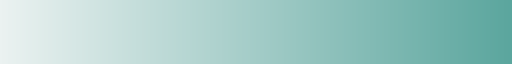

In [13]:
sns.light_palette('#5BA69E', input='rgb', as_cmap=True)

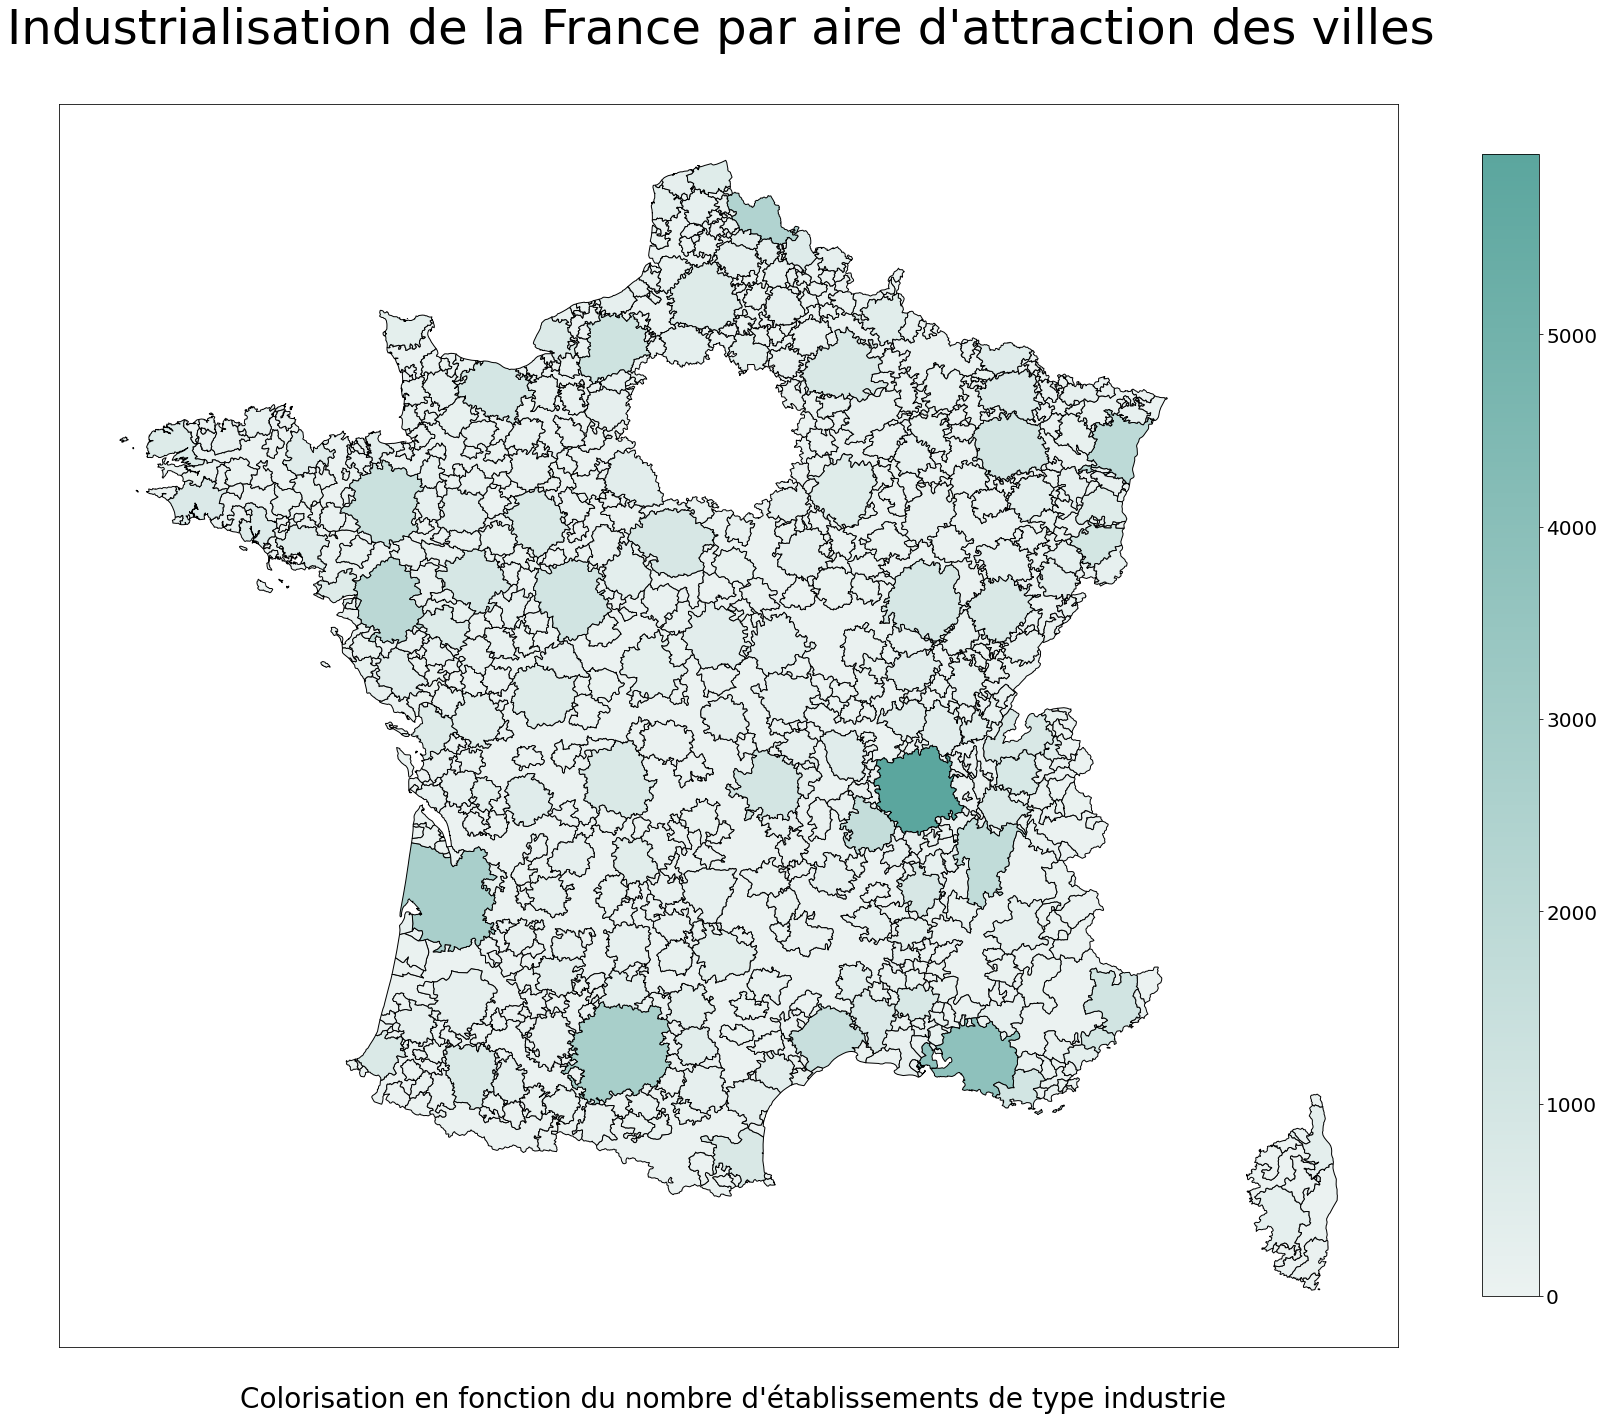

In [14]:
fig, ax = plt.subplots(figsize=(30,30))
gdf_ets_aav_no_paris.plot( 
                ax=ax,
                column="ets_industrie",
                edgecolor='black',
                cmap=sns.light_palette('#5BA69E', input='rgb', as_cmap=True),
                legend=True,
                legend_kwds={'shrink': 0.7}
               )
plt.title('Industrialisation de la France par aire d\'attraction des villes \n', fontsize=48, fontname='sans-serif')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlabel("\n Colorisation en fonction du nombre d'établissements de type industrie", fontsize=28, fontname='sans-serif')
jauge = fig.axes[1]
jauge.tick_params(labelsize=20)
plt.show()

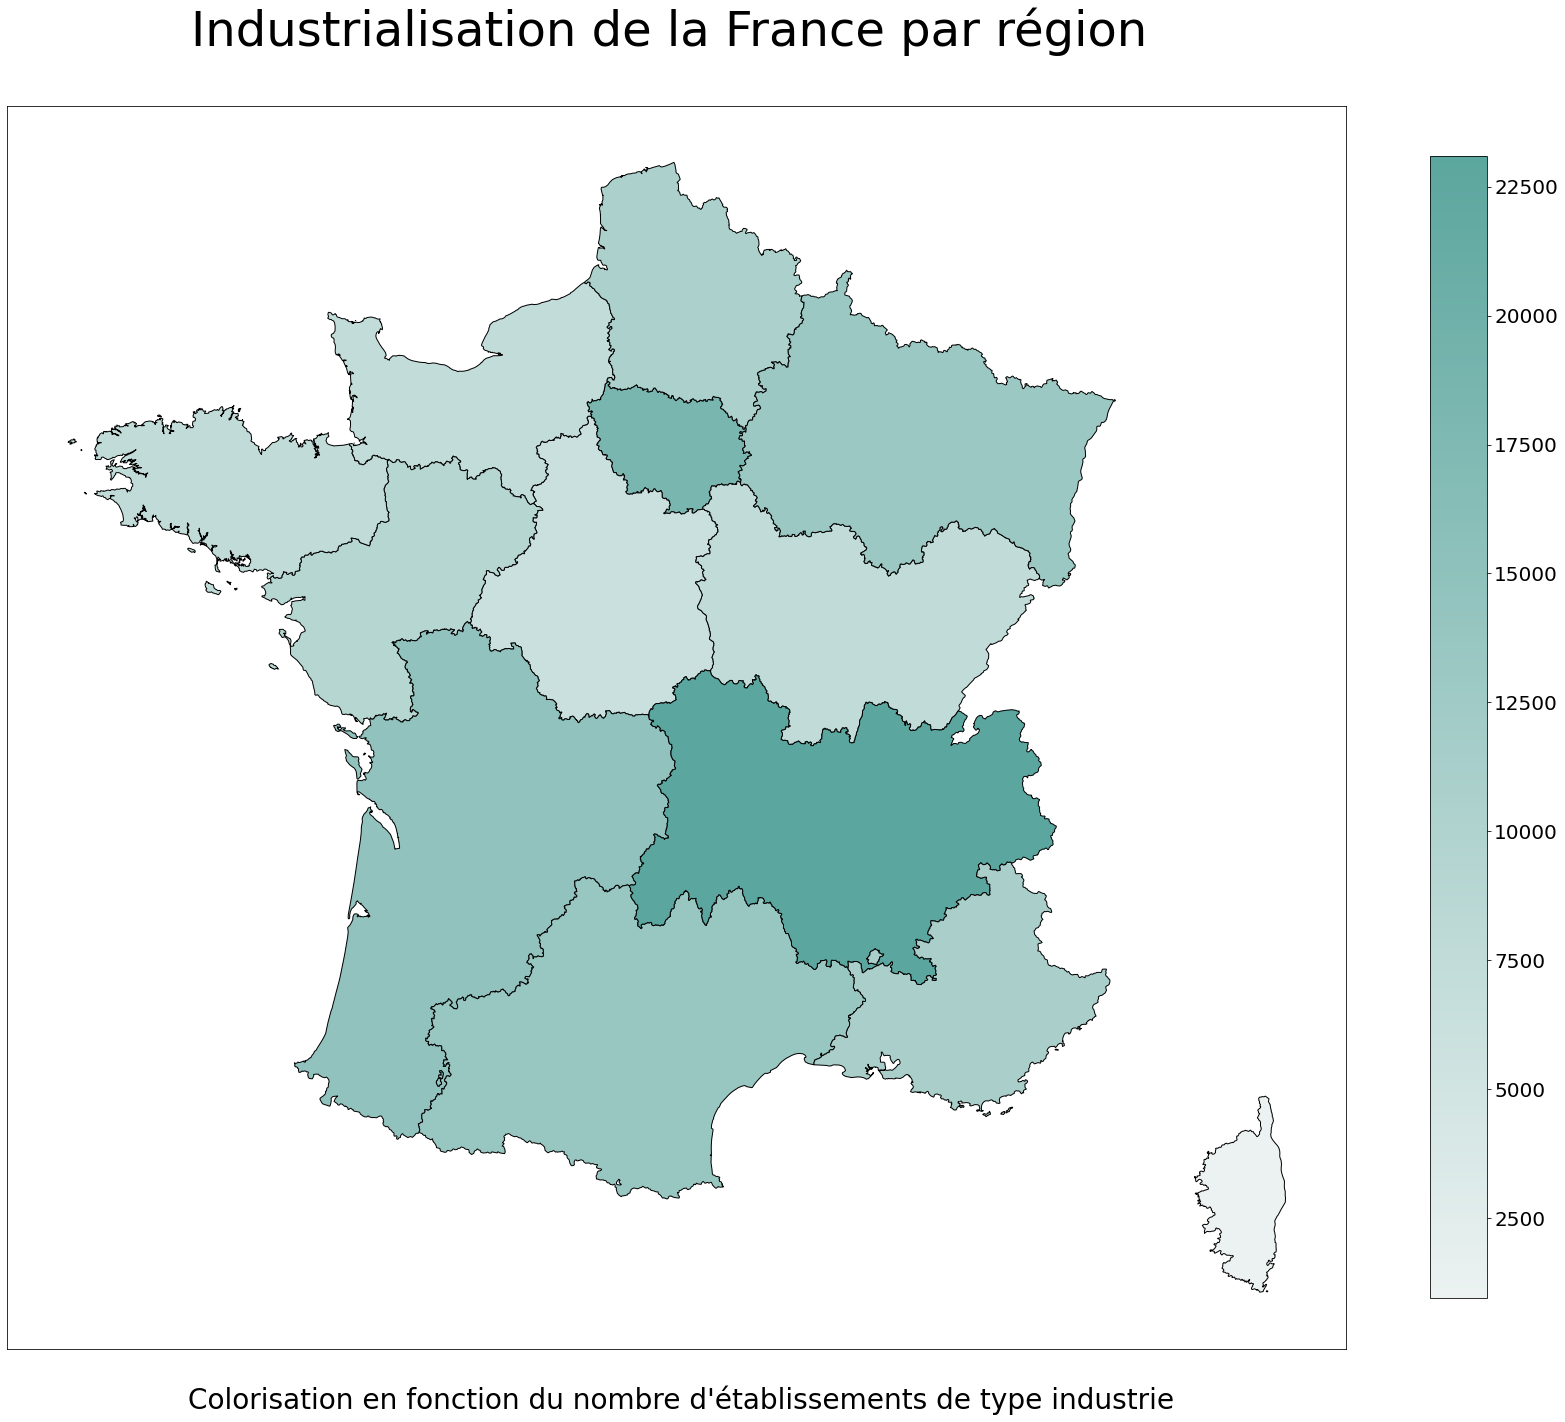

In [15]:
fig, ax = plt.subplots(figsize=(30,30))
gdf_ets_reg.plot( 
                ax=ax,
                column="ets_industrie",
                edgecolor='black',
                cmap=sns.light_palette('#5BA69E', input='rgb', as_cmap=True),
                legend=True,
                legend_kwds={'shrink': 0.7}
               )
plt.title('Industrialisation de la France par région \n', fontsize=48, fontname='sans-serif')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlabel("\n Colorisation en fonction du nombre d'établissements de type industrie", fontsize=28, fontname='sans-serif')
jauge = fig.axes[1]
jauge.tick_params(labelsize=20)
plt.show()

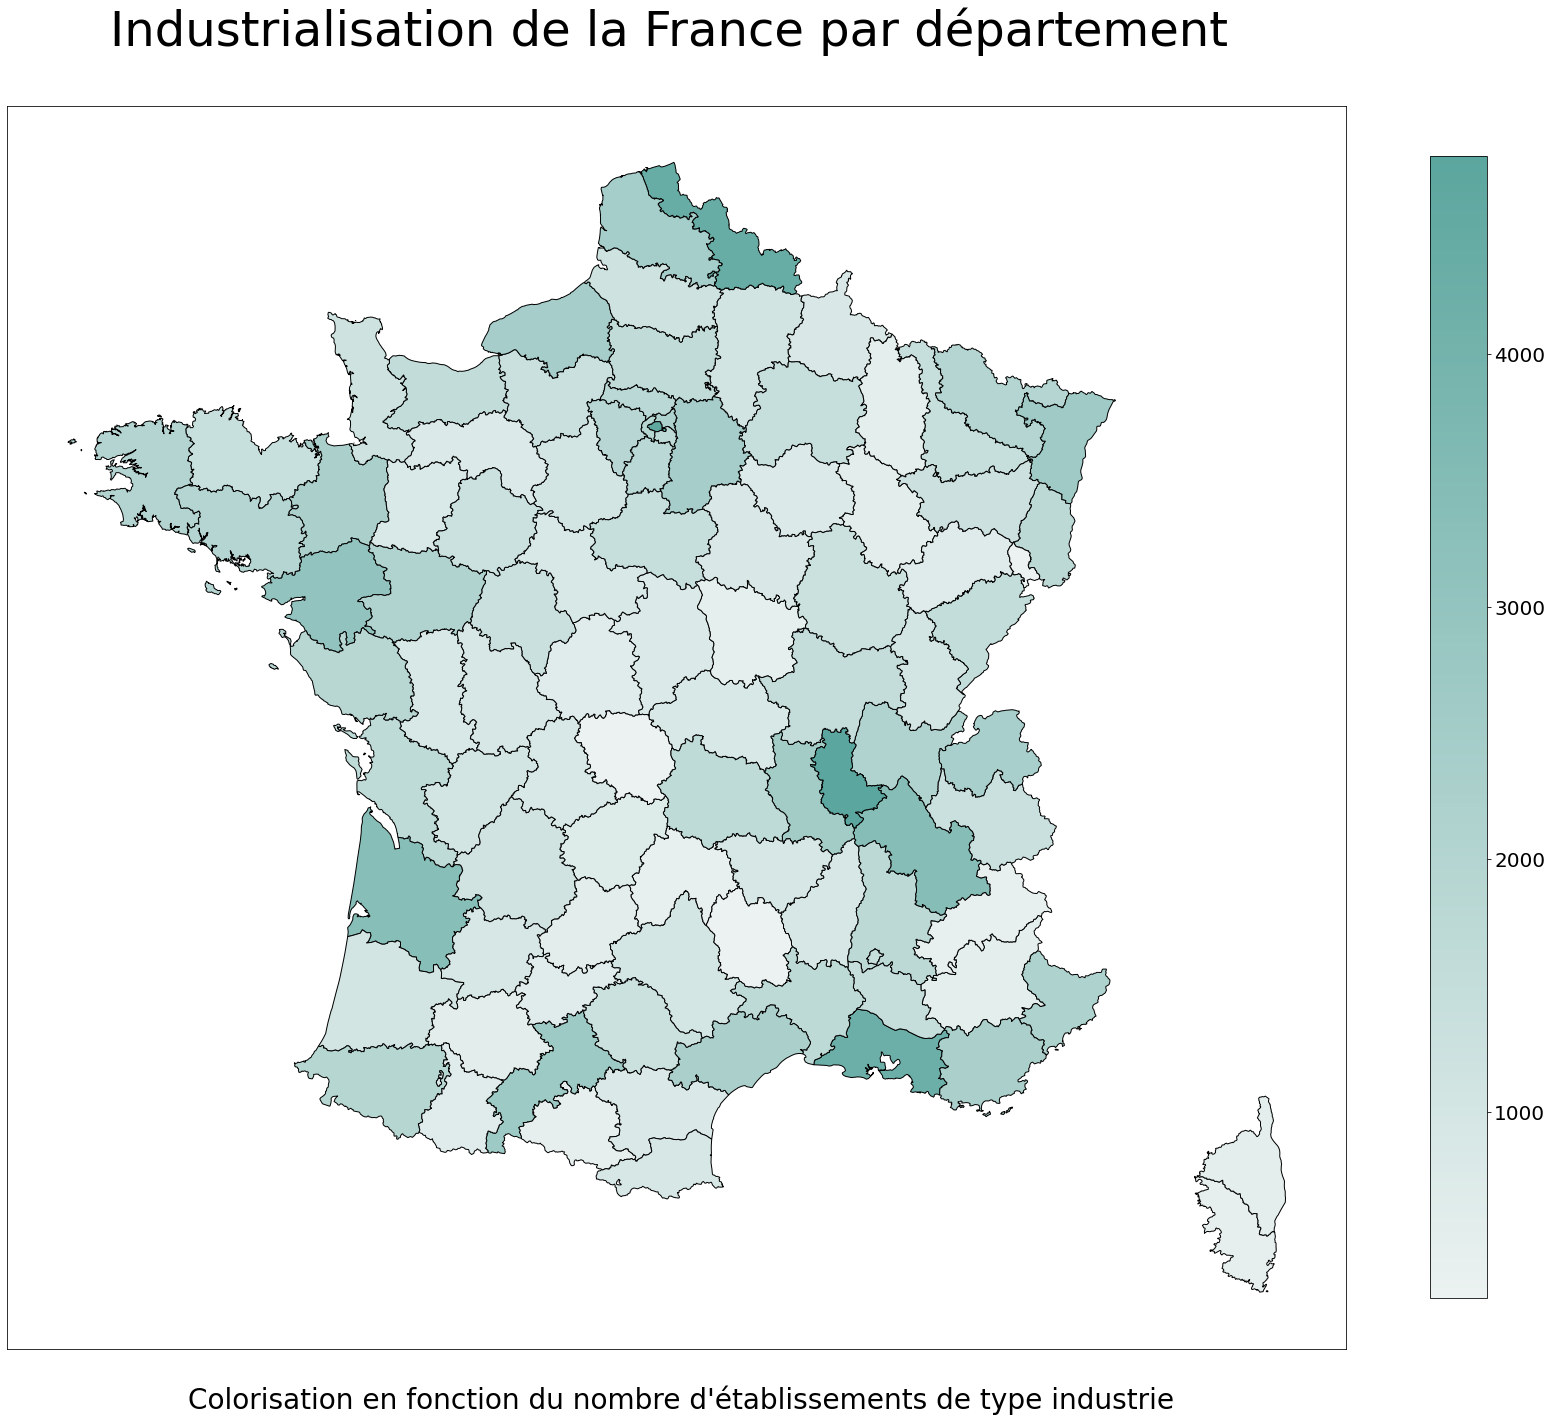

In [16]:
fig, ax = plt.subplots(figsize=(30,30))
gdf_ets_dep.plot( 
                ax=ax,
                column="ets_industrie",
                edgecolor='black',
                cmap=sns.light_palette('#5BA69E', input='rgb', as_cmap=True),
                legend=True,
                legend_kwds={'shrink': 0.7}
               )
plt.title('Industrialisation de la France par département \n', fontsize=48, fontname='sans-serif')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlabel("\n Colorisation en fonction du nombre d'établissements de type industrie", fontsize=28, fontname='sans-serif')
jauge = fig.axes[1]
jauge.tick_params(labelsize=20)
plt.show()

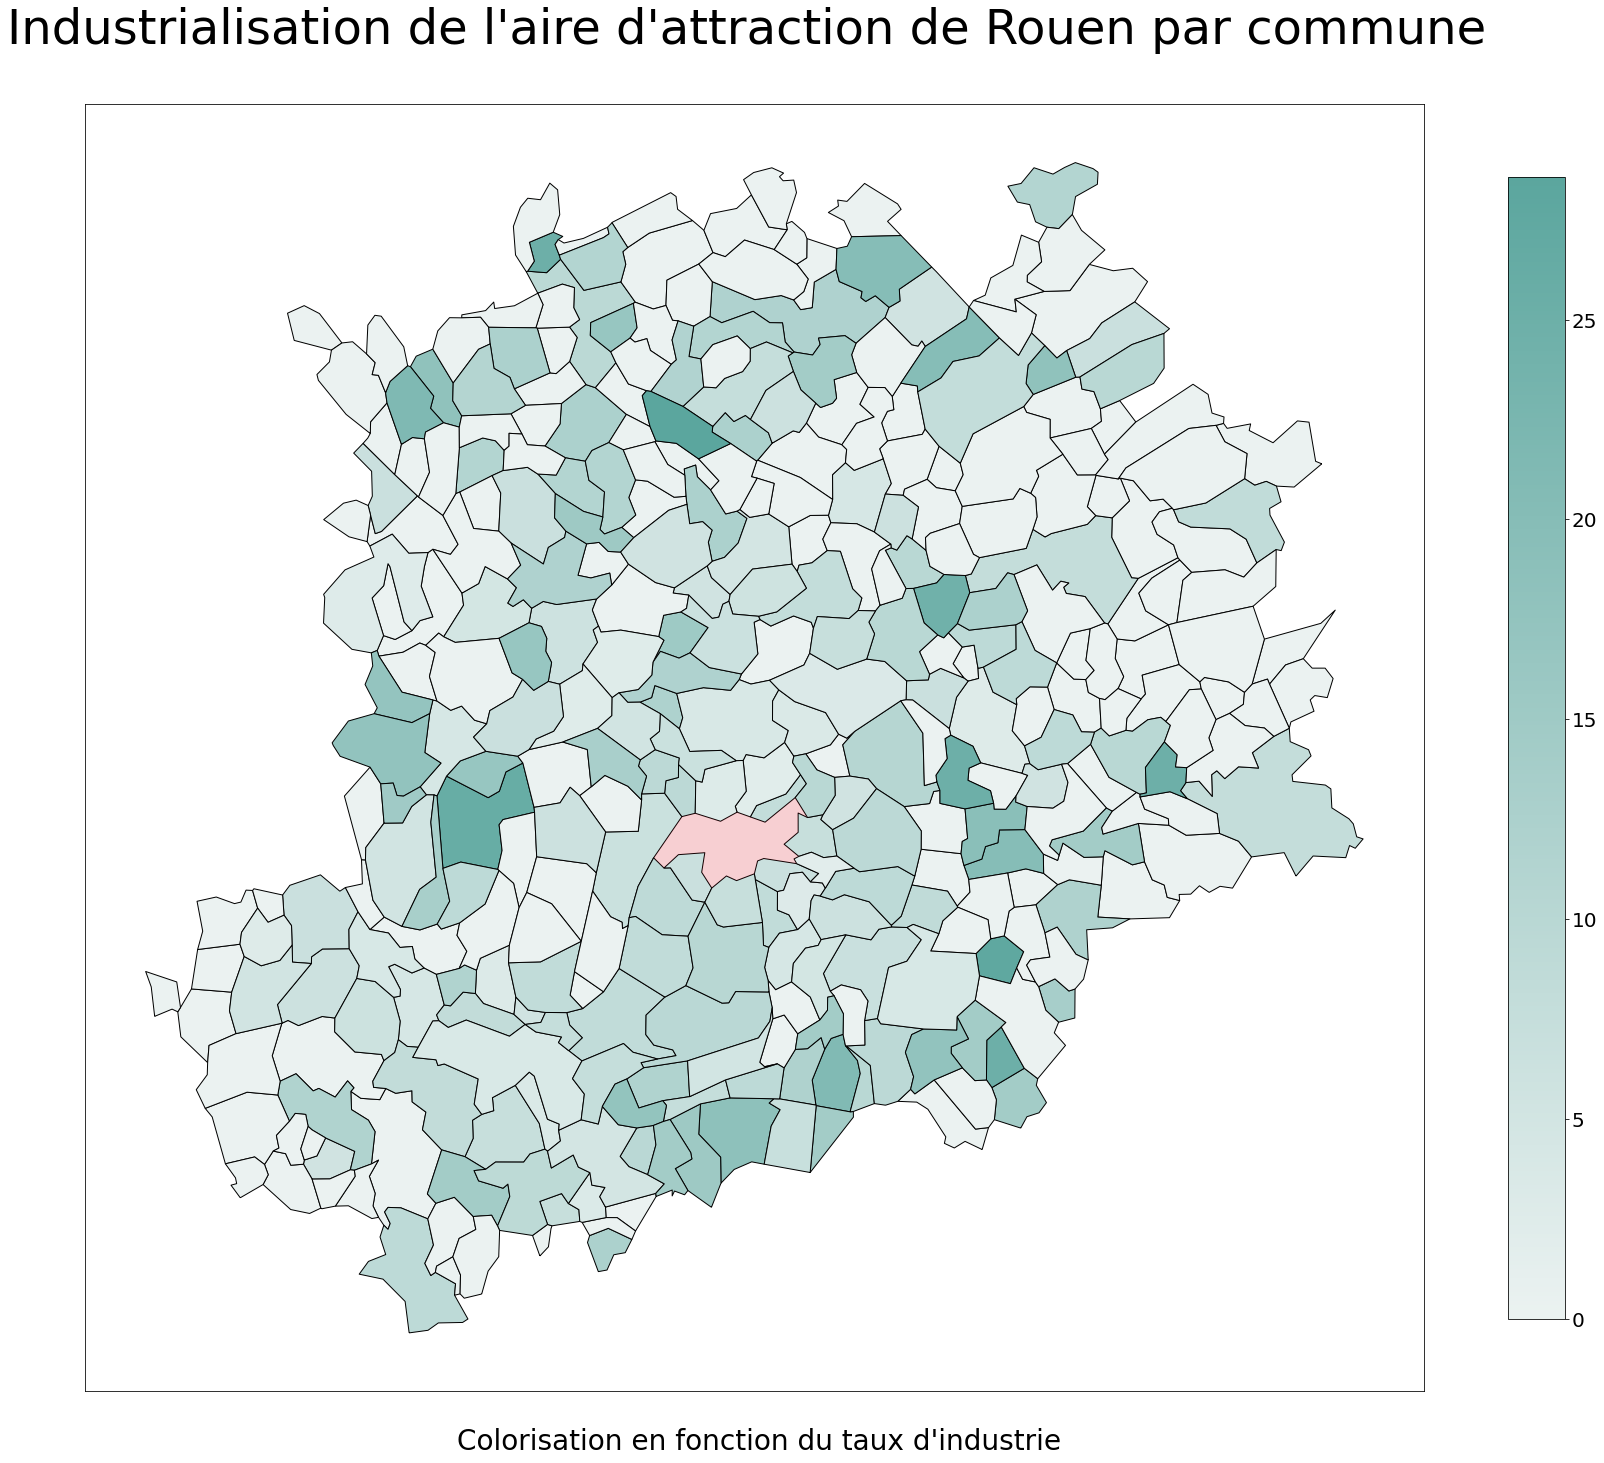

In [17]:
fig, ax = plt.subplots(figsize=(30,30))
gdf_ets_rouen_sub.plot( 
                ax=ax,
                column="tx_industrie",
                edgecolor='black',
                cmap=sns.light_palette('#5BA69E', input='rgb', as_cmap=True),
                legend=True,
                legend_kwds={'shrink': 0.7}
               )
gdf_ets_rouen_only.plot( 
                ax=ax,
                color='#D91122',
                alpha=0.2
               )
plt.title('Industrialisation de l\'aire d\'attraction de Rouen par commune \n', fontsize=48, fontname='sans-serif')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlabel("\n Colorisation en fonction du taux d'industrie", fontsize=28, fontname='sans-serif')
jauge = fig.axes[1]
jauge.tick_params(labelsize=20)
plt.show()

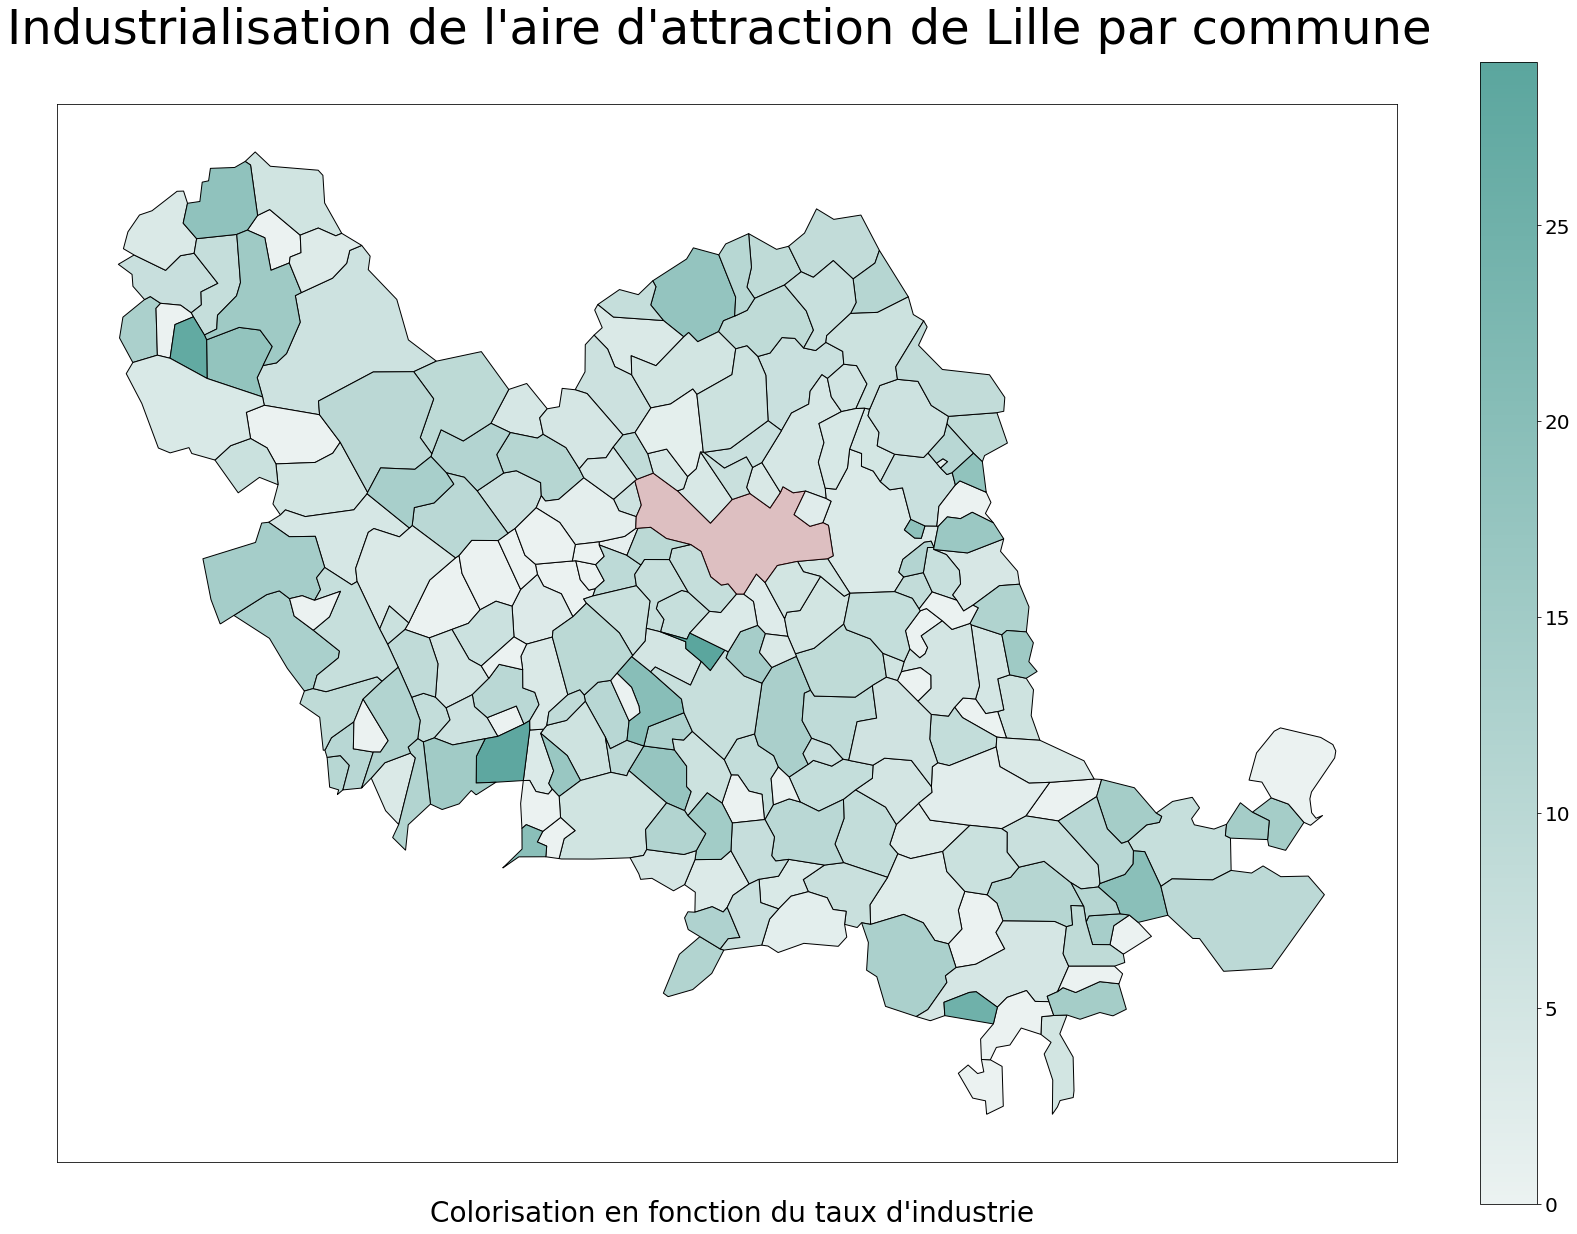

In [27]:
fig, ax = plt.subplots(figsize=(30,30))
gdf_ets_Lille_sub.plot( 
                ax=ax,
                column="tx_industrie",
                edgecolor='black',
                cmap=sns.light_palette('#5BA69E', input='rgb', as_cmap=True),
                legend=True,
                legend_kwds={'shrink': 0.7}
               )
gdf_ets_Lille_only.plot( 
                ax=ax,
                color='#D91122',
                alpha=0.2
               )
plt.title('Industrialisation de l\'aire d\'attraction de Lille par commune \n', fontsize=48, fontname='sans-serif')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlabel("\n Colorisation en fonction du taux d'industrie", fontsize=28, fontname='sans-serif')
jauge = fig.axes[1]
jauge.tick_params(labelsize=20)
plt.show()

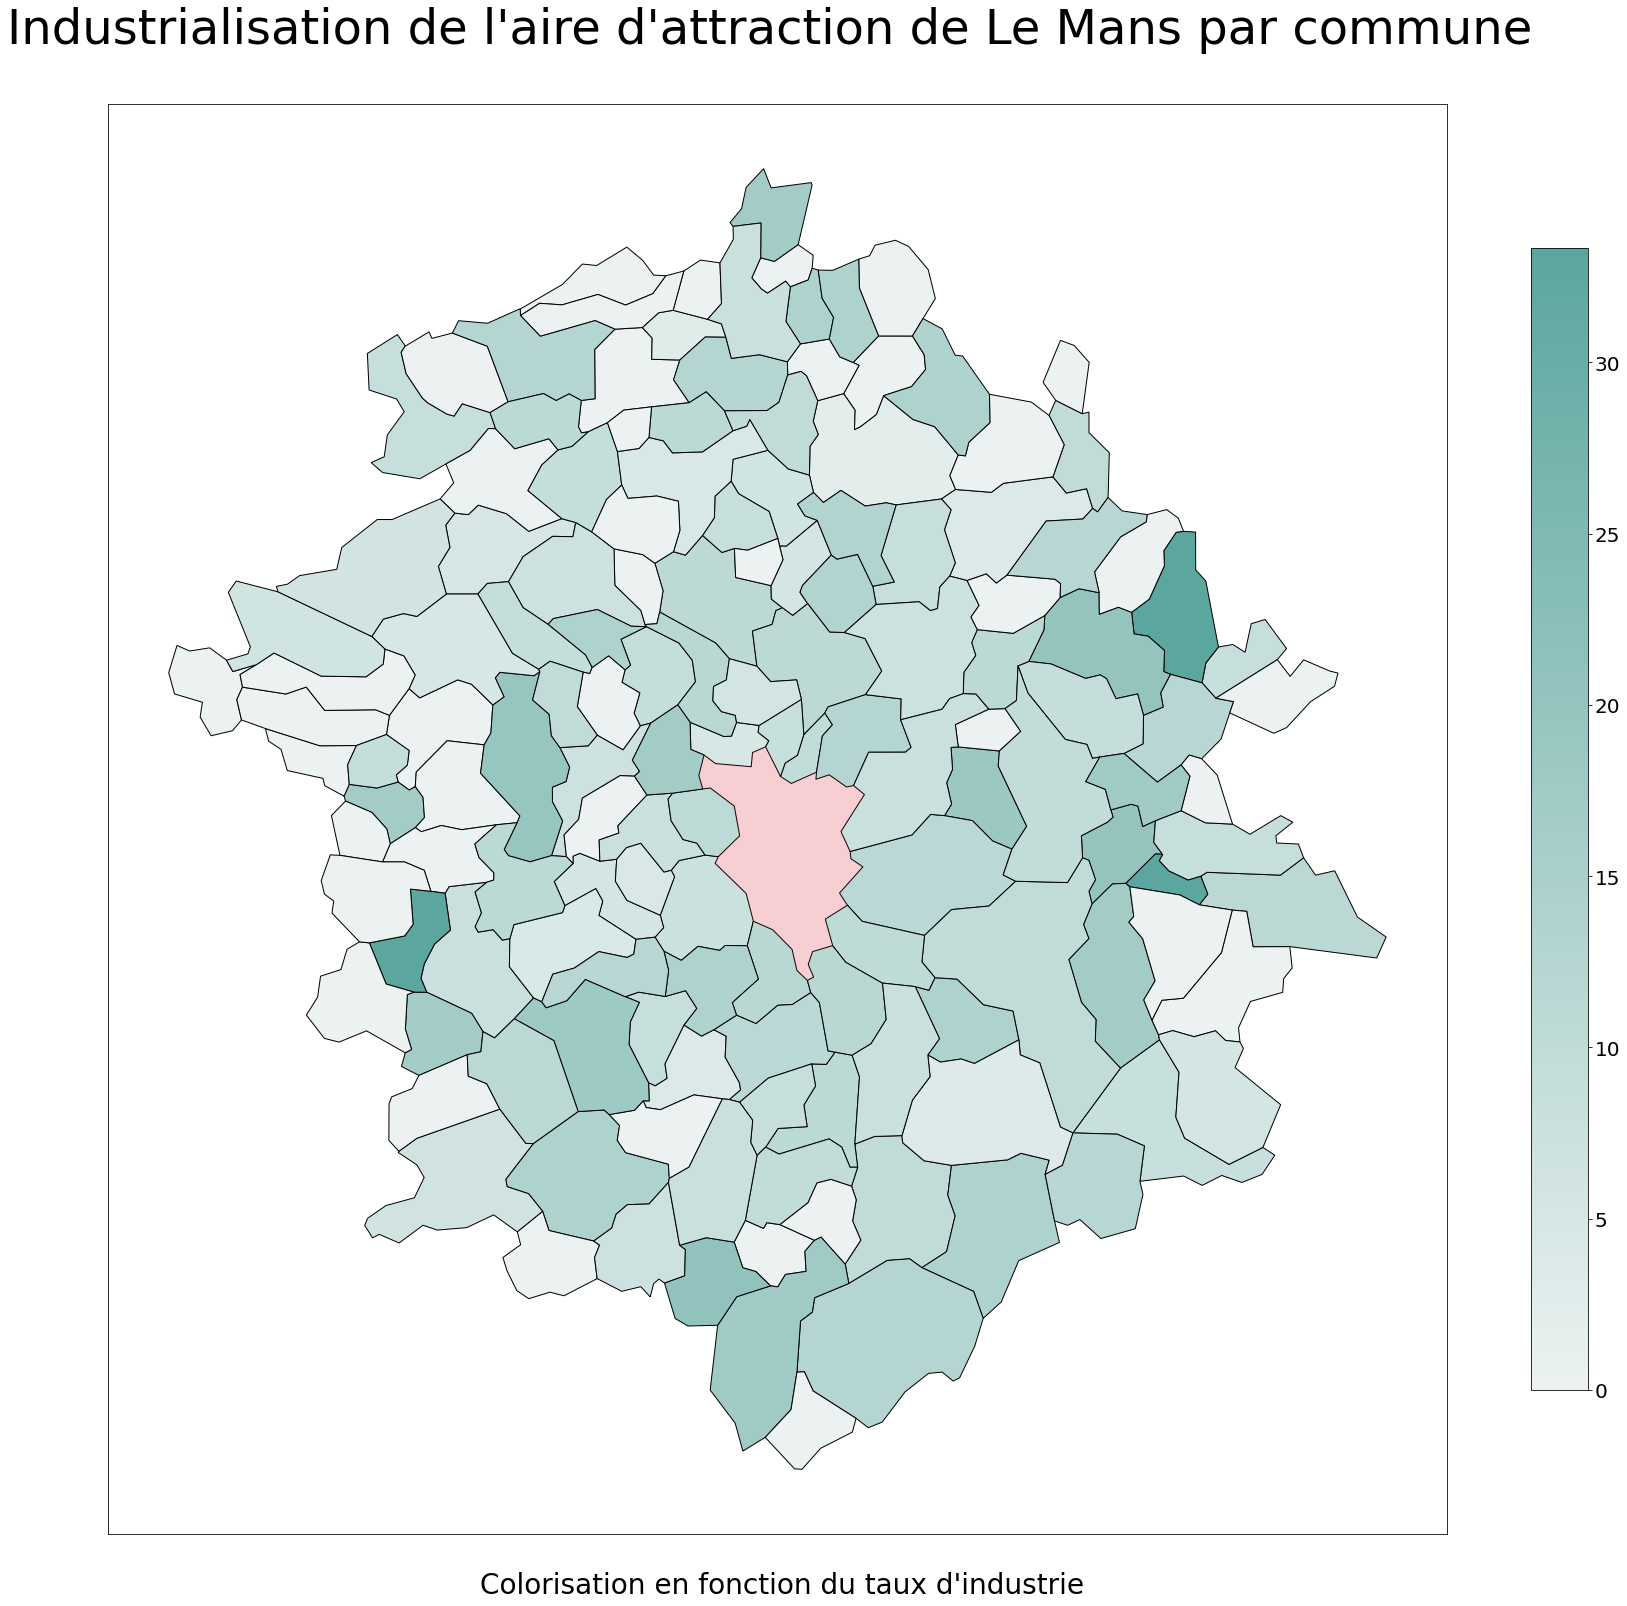

In [33]:
fig, ax = plt.subplots(figsize=(30,30))
gdf_ets_LeMans_sub.plot( 
                ax=ax,
                column="tx_industrie",
                edgecolor='black',
                cmap=sns.light_palette('#5BA69E', input='rgb', as_cmap=True),
                legend=True,
                legend_kwds={'shrink': 0.7}
               )
gdf_ets_LeMans_only.plot( 
                ax=ax,
                color='#D91122',
                alpha=0.2
               )
plt.title('Industrialisation de l\'aire d\'attraction de Le Mans par commune \n', fontsize=48, fontname='sans-serif')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlabel("\n Colorisation en fonction du taux d'industrie", fontsize=28, fontname='sans-serif')
jauge = fig.axes[1]
jauge.tick_params(labelsize=20)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))
gdf_ets_reg.plot( 
                ax=ax,
                column="tx_industrie",
                edgecolor='black',
                cmap='OrRd',
                legend=True,
                legend_kwds={'shrink': 0.7, 'label': 'en %'}
               )
plt.title('Taux d\'industrialisation de la France par région \n', fontsize=48, fontname='sans-serif')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlabel("\n Colorisation en fonction du taux d'établissements de type industrie", fontsize=28, fontname='sans-serif')
jauge = fig.axes[1]
jauge.tick_params(labelsize=20)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))
gdf_ets_dep.plot( 
                ax=ax,
                column="tx_industrie",
                edgecolor='black',
                cmap=sns.light_palette('#5BA69E', input='rgb', as_cmap=True),
                legend=True,
                legend_kwds={'shrink': 0.7, 'label': 'en %'}
               )
plt.title('Taux d\'industrialisation de la France par département \n', fontsize=48, fontname='sans-serif')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlabel("\n Colorisation en fonction du taux d'établissements de type industrie", fontsize=28, fontname='sans-serif')
jauge = fig.axes[1]
jauge.tick_params(labelsize=20)
plt.show()

In [ ]:
gdf_ets_dep